# Imports and type definitions

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
from cycler import cycler

palette = ['#ff0000', '#653700', '#a3cc00', '#06c2ac', '#0088ff', '#db5fff', 
           '#eb3596', '#ef8686', '#ff8800', '#5e664d', '#269991', '#1d3f73', 
           '#7e468c', '#d96236', '#7f2200']

palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIG_SIZE = 18
HUGE_SIZE = 20

plt.style.use('bmh')

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIG_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=BIG_SIZE)       # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=HUGE_SIZE)    # fontsize of the figure title
plt.rc('figure', figsize=(8,6))          # figure size
plt.rc('lines', linewidth=3)             # controls line width
plt.rc('axes', prop_cycle=cycler('color', palette))

In [3]:
%env JAX_ENABLE_X64=1
%env JAX_PLATFORM_NAME=cpu

env: JAX_ENABLE_X64=1
env: JAX_PLATFORM_NAME=cpu


In [4]:
import jax
import jax.numpy as jnp

DeviceArray = jnp.DeviceArray # type alias

In [5]:
import re
import os
import pickle
from typing import List
from functools import reduce

# Constants (as used in the experiment)

For the details refer to the ``settings.txt`` file inside the experiment dir.

In [6]:
# model size (MPS_SIZE * LOCAL_DIM + BOND_DIM = TRAIN_SIZE)
MPS_SIZE = 4
LOCAL_DIM = 4
BOND_DIM = 8

# APPROX RANK
APPROX_RANK = [8]

# NOISE MODEL
PERCENT_NOISE = [0.1] #, 0.5, 1, 5, 10]

# SAVE/PRINT after that many epochs
SAVE_AFTER_EPOCHS = 100

# Helpers

In [7]:
from collections import defaultdict

def idict():
    """Infinitely nested dict"""
    return defaultdict(idict)

def idict2dict(dic):
    """Infinitely nested dict to plain dict"""
    if isinstance(dic, defaultdict):
        dic = {k: idict2dict(v) for k, v in dic.items()}
    return dic

In [8]:
def merge(a, b, path=None):
    "Merges b into a"
    if path is None: path = []
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key], path + [str(key)])
            elif a[key] == b[key]:
                pass # same leaf value
            else:
                raise Exception('Conflict at %s' % '.'.join(path + [str(key)]))
        else:
            a[key] = b[key]
    return a

In [9]:
parent_dir = './experiment/initialisation'

experiment_dirs = [
    '20220402-noise-0.1-glorot-normal',
    '20220402-noise-0.1-he-normal',
    '20220402-noise-0.1-lecun-normal',
    '20220402-noise-0.1-orthogonal'    
]

def find_loss_file(exp_dir):
    for root, _, files in os.walk(exp_dir):
        for file in files:
            if file == 'loss.pkl':
                return os.path.join(root, file)

loss = {
    'train': {}, 
    'test': {}
}

for exp_dir in experiment_dirs:
    dir_path = os.path.join(parent_dir, exp_dir)
    loss_file = find_loss_file(dir_path)
    method = re.sub(r'^(.*\d-)', '', exp_dir)
    with open(loss_file, 'rb') as f:
        data = pickle.load(f)
        loss['train'][method] = jnp.asarray(data['train'][APPROX_RANK[-1]])
        loss['test'][method] = jnp.asarray(data['test'][APPROX_RANK[-1]])

# Plot data

In [10]:
def plot_inits(results, fig_file=None):
    fig, axs = plt.subplots(1, 2, sharey=True, sharex=False)
    plt.subplots_adjust(hspace = 0.5, wspace=0.01)
    for i, (typ, res) in enumerate(results.items()):
        for init_name, data in res.items():
            axs[i].plot(data, label=f'{init_name}')
        axs[i].grid(True)
        axs[i].set_title(typ.capitalize())
        axs[i].legend(loc='upper right')
        axs[i].set_xlabel('Epochs')
        axs[i].set_xlim((0,430))
    fig.text(-.01, 0.5, 'Loss', va='center', rotation='vertical', fontsize=20)
    fig.tight_layout()
    if fig_file:
        plt.savefig(fig_file)

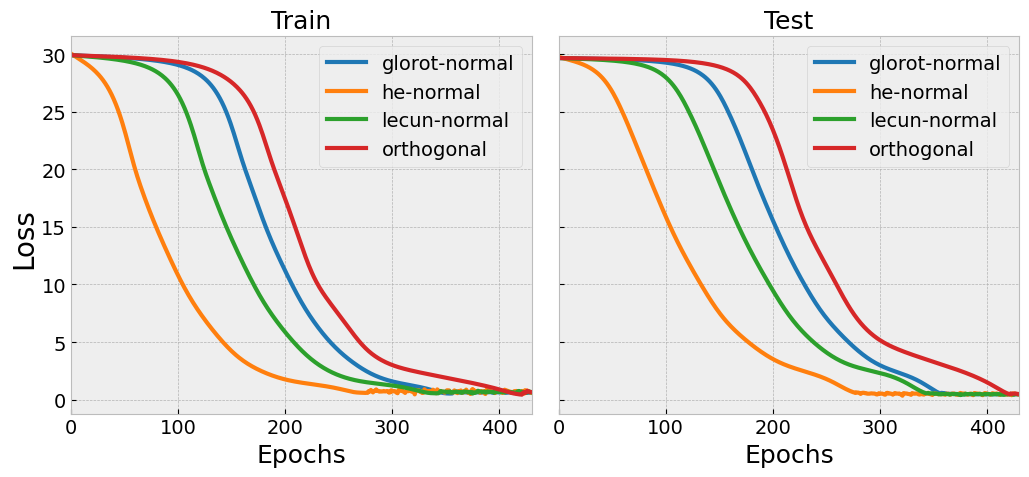

In [11]:
plt.rcParams["figure.figsize"] = (10.2,5)
plot_inits(loss)